In [1]:
import simpy
import networkx as nx

import itertools
import requests
import pickle
import io

import pandas as pd
import geopandas as gpd

import simpy

import itertools

import matplotlib.pyplot as plt

import pint
ureg = pint.UnitRegistry()

In [2]:
url = 'https://zenodo.org/records/6673604/files/network_digital_twin_v0.3.pickle?download=1'
resp = requests.get(url)

In [25]:
graph = pickle.load(io.BytesIO(resp.content))
trips_gdf = gpd.read_parquet('week_38_routes.parquet')

In [5]:
rotterdam_nijmegen = {
    "teu": 10,
    "source": "18008346",
    "source_name": "Rotterdam", 
    "target": "22638188",
    "target_name": "Nijmegen"
}
rotterdam_duisburg = {
    "teu": 10,
    "source": "18008346",
    "source_name": "Rotterdam", 
    "target": "FN96",
    "target_name": "Duisburg"
}

nijmegen_duisburg = {
    "teu": 10,
    "source": "22638188",
    "source_name": "Nijmegen",
    "target": "FN96",
    "target_name": "Duisburg"
}


145699.13091711738

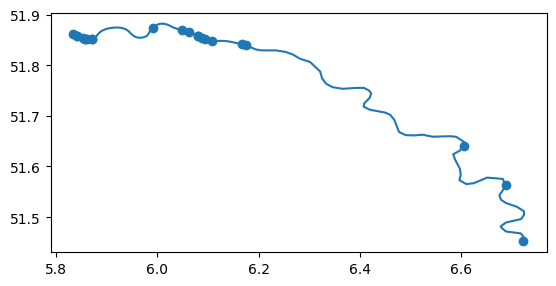

In [6]:
def get_route_gdfs(scenario):
    route = nx.shortest_path(graph, source=scenario["source"], target=scenario["target"], weight="length_m")


    nodes = []
    for n in route:
        node = graph.nodes[n]
        nodes.append(node)
    
    node_df = pd.DataFrame(nodes)
    geometry = gpd.GeoSeries.from_wkt(node_df['Wkt'])
    node_gdf = gpd.GeoDataFrame(node_df, geometry=geometry)

    edges = []
    for a, b in zip(route[:-1], route[1:]):
        edge = graph.edges[(a, b)]
        edges.append(edge)

    edge_df = pd.DataFrame(edges)
    geometry = gpd.GeoSeries.from_wkt(edge_df['Wkt'])
    edge_gdf = gpd.GeoDataFrame(edge_df, geometry=geometry)
    
    
    result = {"edge": edge_gdf, "node": node_gdf}
    return result

scenario = nijmegen_duisburg

route_gdfs = get_route_gdfs(scenario)
edge_gdf = route_gdfs["edge"]
node_gdf = route_gdfs["node"]

fig, ax = plt.subplots()

edge_gdf.plot(ax=ax)
node_gdf.plot(ax=ax)
    
edge_gdf["length_m"].sum()

In [43]:
source_gdf = trips_gdf.groupby(["source"])['v30_4_Containers_TEU_S'].agg(["sum", "count"])
target_gdf = trips_gdf.groupby(["target"])['v30_4_Containers_TEU_S'].agg(["sum", "count"])
trips_gdf_agg = trips_gdf.groupby(["route"])['v30_4_Containers_TEU_S'].agg(["sum", "count"])
trips_gdf_agg

,sum,count
route,,
Duisburg-Nijmegen,537.0,7
Duisburg-Rotterdam,18583.0,794
Nijmegen-Duisburg,473.0,7
Nijmegen-Rotterdam,5274.0,56
Rotterdam-Duisburg,23334.0,810
Rotterdam-Nijmegen,6413.0,64


In [58]:
env = simpy.Environment()

In [59]:
def create_container(row, env, fill):
    if fill:
        init = row['sum']
    else:
        init = 0
    
    container = simpy.Container(env=env, capacity=row['sum'], init=init)
    return container
    
source_gdf["container"] = source_gdf.apply(create_container, env=env, fill=True, axis=1)
target_gdf["container"] = target_gdf.apply(create_container, env=env, fill=False, axis=1)
trips_gdf_agg["container"] = trips_gdf_agg.apply(create_container, env=env, fill=True, axis=1)
trips_gdf_agg

,sum,count,container
route,,,
Duisburg-Nijmegen,537.0,7,<simpy.resources.container.Container object at...
Duisburg-Rotterdam,18583.0,794,<simpy.resources.container.Container object at...
Nijmegen-Duisburg,473.0,7,<simpy.resources.container.Container object at...
Nijmegen-Rotterdam,5274.0,56,<simpy.resources.container.Container object at...
Rotterdam-Duisburg,23334.0,810,<simpy.resources.container.Container object at...
Rotterdam-Nijmegen,6413.0,64,<simpy.resources.container.Container object at...


In [60]:
trips_gdf_rotterdam_source = trips_gdf[trips_gdf['source'] == 'Rotterdam']
trip = trips_gdf_rotterdam_source.iloc[0]

In [61]:
trip = {
    "source": "Rotterdam",
    "target": "Duisburg",
    "target_hub": "Nijmegen",
    "ship_cargo": simpy.Container(env, capacity=200, init=0)
}

In [62]:
def load(trip):
    route = f"{trip['source']}-{trip['target']}"
    source_container = trips_gdf_agg.loc[route, "container"]
    ship_container = trip["ship_cargo"]
    if trip["target_hub"] != trip["target"]:
        route = f"{trip['target_hub']}-{trip['target']}"
        target_container = trips_gdf_agg.loc[route, "container"]
    else:
        target_container = target_gdf.loc[trip["target"], "container"]
    
    loading_rate = 20
    with (
        source_container.get(ship_container.capacity) as get_req, 
        ship_container.put(ship_container.capacity) as put_req,
    ):
        print("Loading cargo", env.now)
        yield get_req
        yield put_req
        yield env.timeout(ship_container.capacity * loading_rate)
        print("Cargo loaded", env.now)

env.process(load(trip))
env.run()

Loading cargo 0
Cargo loaded 4000


In [63]:
ship_container.level

200

In [18]:
def transport_hubs(env, scenario):
    # get cargo from source
    # collection of sources and destinations

    max_capacity = 100
    ship_cargo = simpy.Container(env, capacity=max_capacity, init=0)
    remaining_capacity = ship_cargo.capacity  - ship_cargo.level
    to_duisburg = min(cargo_rotterdam_to_duisburg.level, max_capacity)

    # load cargo for duisburg first
    with (
        cargo_rotterdam_to_duisburg.get(to_duisburg) as get_req, 
        ship_cargo.put(to_duisburg) as put_req,
    ):
        yield get_req
        yield put_req
        yield env.timeout(to_duisburg * loading_rate_rotterdam)

    # then load cargo to nijmegen
    remaining_capacity = ship_cargo.capacity  - ship_cargo.level
    to_nijmegen = min(cargo_rotterdam_to_duisburg.level, max_capacity)
    with (
        cargo_rotterdam_to_nijmegen.get(to_nijmegen) as get_req, 
        ship_cargo.put(to_nijmegen) as put_req,
    ):
        yield get_req
        yield put_req
        yield env.timeout(to_nijmegen * loading_rate_rotterdam)

    
    # delay with estimate of loading time
    # bring all cargo to hub
    scenario = rotterdam_nijmegen
    route_gdfs = get_route_gdfs(scenario)
    edge_gdf = route_gdfs["edge"]
    node_gdf = route_gdfs["node"]

    route_length_m = edge_gdf["length_m"].sum()
    velocity = 4
    duration = route_length_m / velocity # m / m/s = m * s / m = s
    yield env.timeout(duration)

    cargo_nijmegen_to_duisburg

    
    
    


In [14]:
env = simpy.Environment()
env.process(transport(env, scenario))
env.run()
(env.now * ureg.seconds).to(ureg.hours)

25.65401952151109 <Unit('hour')>